In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F

from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os

In [32]:
RGB2YUV_matrix = torch.tensor([[0.299, 0.587, 0.114],
                                [-0.147, -0.289, 0.436],
                                [0.615, -0.515, -0.100]])

YUV2RGB_matrix = torch.tensor([[1, 0, 1.140],
                               [1, -0.395, -0.581],
                               [1, 2.032, 0]])

In [33]:
class RGB2YUV(object):
    def __call__(self, rgb_image):
        yuv_tensor = self.rgb_to_yuv(rgb_image)
        return yuv_tensor

    def rgb_to_yuv(self, rgb_tensor):
        yuv_tensor = torch.matmul(RGB2YUV_matrix, rgb_tensor.view(3, -1))
        yuv_tensor = yuv_tensor.view(rgb_tensor.size())
        return yuv_tensor

def YUV2RGB(YUV_tensor, islabel=True):
    rgb_tensor = torch.matmul(YUV2RGB_matrix, YUV_tensor.view(3,-1))
    if(islabel):
        return rgb_tensor.view(YUV_tensor.shape)
    else:
        r_max = rgb_tensor[0].max()
        r_min = rgb_tensor[0].min()
        g_max = rgb_tensor[1].max()
        g_min = rgb_tensor[1].min()
        b_max = rgb_tensor[2].max()
        b_min = rgb_tensor[2].min()
        r_norm = (rgb_tensor[0] - r_min)/(r_max - r_min)
        g_norm = (rgb_tensor[1] - g_min)/(g_max - g_min)
        b_norm = (rgb_tensor[2] - b_min)/(b_max - b_min)
        return torch.stack([r_norm, g_norm, b_norm]).view(YUV_tensor.shape)

In [34]:
# visualize functions
def imshow(img, is_gray=False):
    # Undo normalization
    # img = img * 0.5 + 0.5
    npimg = img.numpy()
    if is_gray:
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def save_visualize(inputs, labels, predicts, num, title, n=5):
    labels_yuv = torch.cat([inputs, labels], dim=1)
    predicts_yuv = torch.cat([inputs, predicts], dim=1)

    plt.suptitle(f"{title}_epoch{num}")
    for i in range(n):
        plt.subplot(3, n, i + 1)  # Display grayscale images in the first row
        imshow(inputs[i], True)

        plt.subplot(3, n, i + 1 + n)  # Display sample color images in the second row
        imshow(YUV2RGB(labels_yuv[i]))  # Assuming sample_color images are already in CPU and normalized

        plt.subplot(3, n, i + 1 + 2 * n)  # Display predicted color images in the third row
        imshow(YUV2RGB(predicts_yuv[i]))  # Assuming predicted images are already in CPU and normalized

    if not os.path.exists('visualize'):
        os.makedirs('visualize')
    plt.savefig(f'visualize/{title}_epoch{num}.png')
    plt.show()
    plt.close()

def plot_losses(epochs, train_losses, test_losses, valid_losses):
    epochs = list(range(1, epochs + 1))
    # plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training')
    plt.plot(epochs, test_losses, label='Testing ')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"visualize/loss_plot.png")
    plt.show()
    plt.close()


In [35]:
class CIFAR10GrayColorPair(Dataset):
    def __init__(self, root, train=True, download=True):
        self.color_transform = transforms.Compose([
            transforms.ToTensor(),
            RGB2YUV(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # Load CIFAR-10 dataset
        self.color_dataset = datasets.CIFAR10(root=root, train=train, download=download, transform=self.color_transform)

    def __getitem__(self, index):
        # Get the color image and its corresponding gray image
        yuv_img, _ = self.color_dataset[index]
        return yuv_img[0].view(1,32,32), yuv_img[1:]

    def __len__(self):
        return len(self.color_dataset)

cifar10_gray_color_pair_dataset = CIFAR10GrayColorPair(root='./data', train=True, download=True)
test_dataset = CIFAR10GrayColorPair(root='./data', train=False, download=True)
train_dataset, validation_dataset = random_split(cifar10_gray_color_pair_dataset, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [36]:
class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(),
        )
    def forward(self,x):
        return self.layer(x)

class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)

class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.ConvTranspose2d(channel,channel//2,2,2)
    def forward(self,x,feature_map):
        out=self.layer(x)
        return torch.cat((out,feature_map),dim=1)

class UNet_complex(nn.Module):
    def __init__(self, num_filters):
        super(UNet_complex, self).__init__()
        self.c1=Conv_Block(1,num_filters)
        self.d1=DownSample(num_filters)
        self.c2=Conv_Block(num_filters,num_filters*2)
        self.d2=DownSample(num_filters*2)
        self.c3=Conv_Block(num_filters*2,num_filters*4)
        self.d3=DownSample(num_filters*4)

        self.c4=Conv_Block(num_filters*4,num_filters*8)
        self.u1=UpSample(num_filters*8)

        self.c5=Conv_Block(num_filters*8,num_filters*4)
        self.u2 = UpSample(num_filters*4)
        self.c6 = Conv_Block(num_filters*4, num_filters*2)
        self.u3 = UpSample(num_filters*2)
        self.c7 = Conv_Block(num_filters*2, num_filters)
        self.out = nn.Conv2d(num_filters,2,3,1,1)
        self.tanh = nn.Tanh()

    def forward(self,x):
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3=self.c3(self.d2(R2))

        R4 = self.c4(self.d3(R3))

        O1=self.c5(self.u1(R4,R3))
        O2 = self.c6(self.u2(O1, R2))
        O3 = self.c7(self.u3(O2, R1))

        return self.tanh(self.out(O3))


In [37]:
def test(model, validation_loader, test_loader):
    model.eval()
    total_valid_loss = 0.0
    total_test_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
            images=images.cuda()
            labels=labels.cuda()
            outputs = model(images)
            total_valid_loss += criterion(outputs, labels).item()
        valid_loss = total_valid_loss / len(validation_loader)

        for images, labels in test_loader:
            images=images.cuda()
            labels=labels.cuda()
            outputs = model(images)
            total_test_loss += criterion(outputs, labels).item()
        test_loss = total_test_loss / len(test_loader)

    return valid_loss, test_loss

In [38]:
def train(model, criterion, lr, num_epochs, batch_size):
    model=model.to('cuda')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=500, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []
    test_losses = []

    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images=images.cuda()
            labels=labels.cuda()

            outputs = model(images)

            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)

        valid_loss, test_loss = test(model, validation_loader, test_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        test_losses.append(test_loss)

        # visualize every n epoch
        if epoch%10 == 0:
            model.eval()
            with torch.no_grad():
                images, labels = next(iter(train_loader))
                outputs = model(images.cuda())
                save_visualize(images[0:5].cpu(), labels[0:5], outputs[0:5].cpu(), epoch, "train")

                images, labels = next(iter(validation_loader))
                outputs = model(images.cuda())
                save_visualize(images[0:5].cpu(), labels[0:5], outputs[0:5].cpu(), epoch, "validation")

                images, labels = next(iter(test_loader))
                outputs = model(images.cuda())
                save_visualize(images[0:5].cpu(), labels[0:5], outputs[0:5].cpu(), epoch, "test")

            # torch.save(model.state_dict(), f"weights/complex_epoch{epoch}_loss_{test_loss:.4f}.pth")

    return train_losses, valid_losses, test_losses

In [39]:
unet_complex = UNet_complex(32)

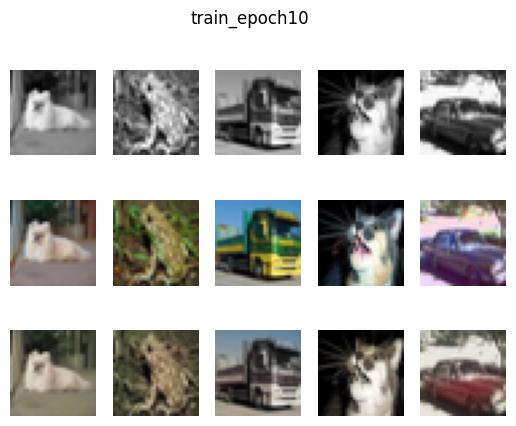

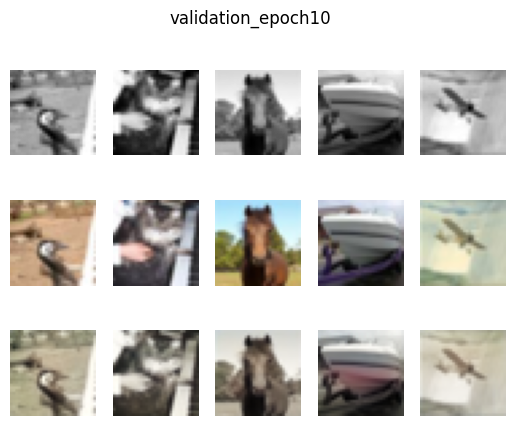

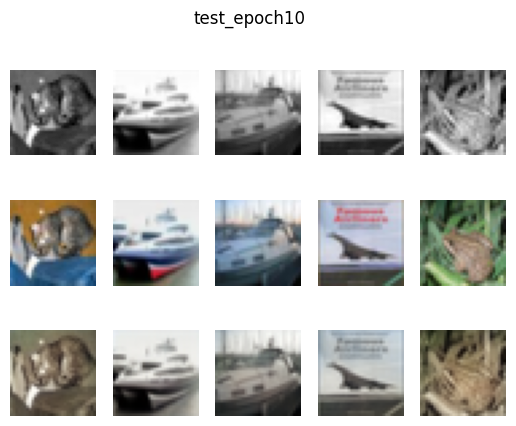

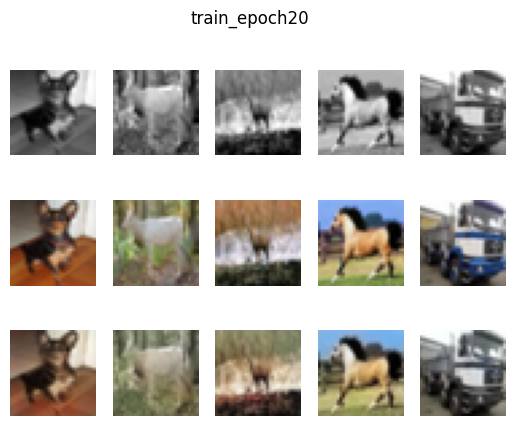

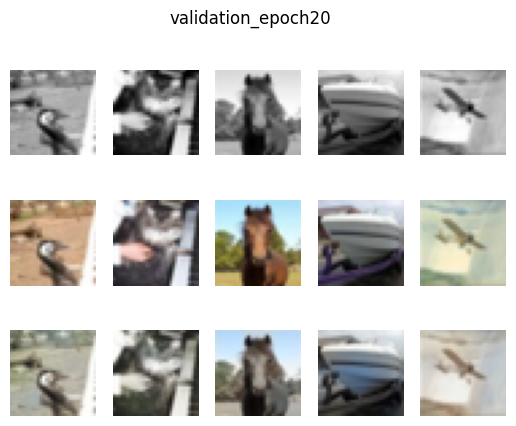

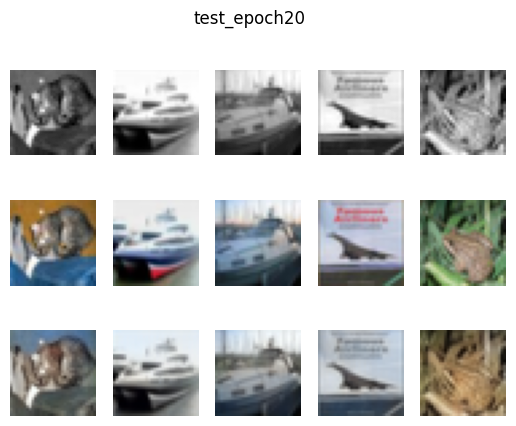

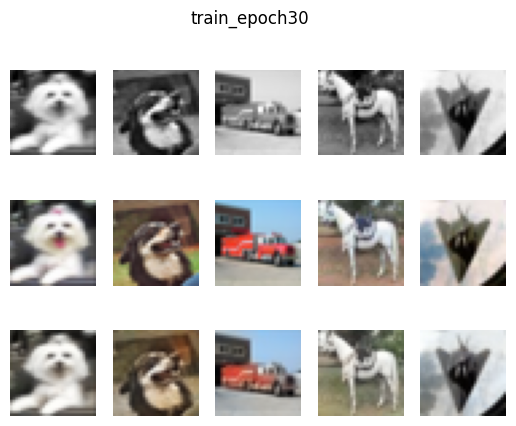

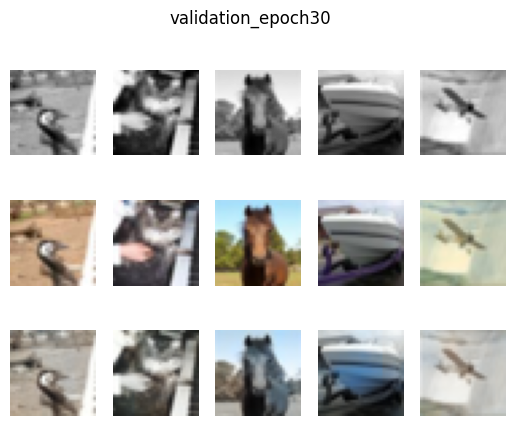

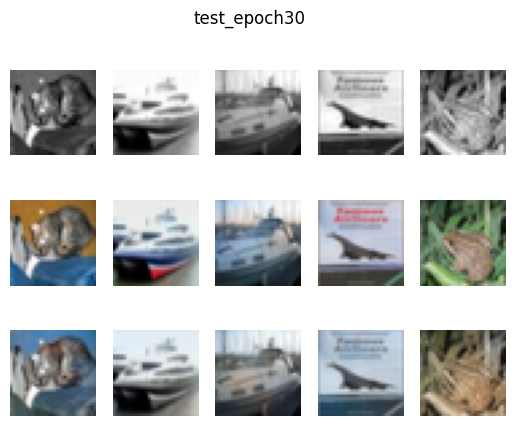

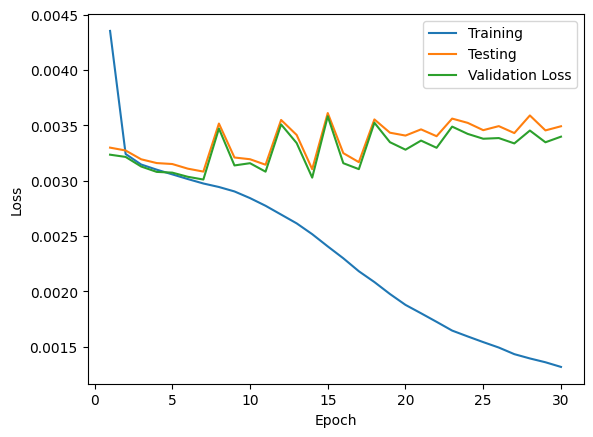

In [40]:
criterion = nn.MSELoss()
num_epochs = 30
train_losses, valid_losses, test_losses = train(unet_complex, criterion, 0.001, num_epochs, 64)
plot_losses(num_epochs, train_losses, valid_losses, test_losses)